# Batch correction and integrated analysis of ependymoma samples
Regrettably, seems gojo et al aggregated all of their sequencing by sample, so impossible now to
batch correct on sequencing type (scSmart-seq2, snSmart-seq2, 10X Genomics) without reanalyzing from scratch.


In [1]:
# Load all required libraries
Sys.setenv(LANGUAGE = "en") # set language to "ja" if you prefer
library(Seurat)
library(tidyverse)
library(harmony)
library(ggplot2)
library(future)
library(ggalluvial)
library(mclust)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Rcpp

Packa

In [2]:
# Set parallel execution settings
future::plan("multisession", workers = availableCores()-1)
options(future.globals.maxSize = 1024*8*1024^2) # Set max variable size to 8Gb

In [3]:
# Load data
DATA_DIR = file.path('data','external','gojo_et_al') # change this if you put your data somewhere other than ./data/external/gojo_et_al/
import_gojo_data <- function(counts_file,metadata_file,path){
    counts_path = file.path(DATA_DIR,counts_file)
    metadata_path = file.path(DATA_DIR,metadata_file)
    counts = read.table(counts_path)
    meta = read.table(metadata_path)    
    obj <- CreateSeuratObject(counts = counts , meta.data = meta) %>% suppressWarnings
    return(obj)
}
clean_pdx <- function(pdx){
    # clean the pdx metadata.
    # Delete column V1 (duplicate of row indices)
    # rename column V2
    names(pdx[[]])[names(pdx[[]]) == 'V2'] <- 'sample'
    pdx@meta.data[c('V1','V2')] <- NULL
    pdx$annotation <- pdx$sample
    return(pdx)
}

In [4]:
# we're loading a lot of data so this will take a long time
pf = import_gojo_data('PF_EPN_counts_200519lj.txt','PF_EPN_metadata_200519lj.txt',DATA_DIR)
sp = import_gojo_data('SP_EPN_counts_200519lj.txt','SP_EPN_metadata_200519lj.txt',DATA_DIR)
st = import_gojo_data('ST_EPN_counts_200519lj.txt','ST_EPN_metadata_200519lj.txt',DATA_DIR)
pdx = import_gojo_data('PDX_counts.txt','PDX_metadata.txt',DATA_DIR) %>% clean_pdx
pairs = import_gojo_data('Matched_pair_counts_200519lj.txt','Matched_pair_metadata_200519lj.txt',DATA_DIR)

pf
sp
st
pdx
pairs

An object of class Seurat 
23686 features across 3983 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

An object of class Seurat 
23686 features across 338 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

An object of class Seurat 
23686 features across 2021 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

An object of class Seurat 
23686 features across 256 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

An object of class Seurat 
23686 features across 652 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

In [5]:
# merge into 1 dataset
gojo <- merge(pf, y=c(sp,st,pdx,pairs)) %>% JoinLayers
gojo
# list samples
get_sample_names <- function(seuratobject){
    return(seuratobject@meta.data$sample %>% unique())
}
get_sample_names(gojo)

An object of class Seurat 
23686 features across 7250 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

[1] "BT1313"             "BT1334"             "BT1412Nuc"         
 [4] "BT1480Nuc"          "MUV013"             "MUV014"            
 [7] "MUV018"             "MUV021"             "MUV038"            
[10] "MUV051"             "MUV052"             "MUV053"            
[13] "MUV063"             "MUV071"             "BT1678"            
[16] "MUV068"             "BT1030"             "CPDM0785"          
[19] "MUV006"             "MUV043"             "MUV043Nuc1"        
[22] "MUV043Nuc2"         "MUV056"             "Peds4"             
[25] "BT165PDX"           "BT214PDX"           "WEPN1DiaANGANuc"   
[28] "WEPN1RecDUDRNuc"    "WEPN20DiaVEMI00Nuc" "WEPN20RecVEMI01Nuc"

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


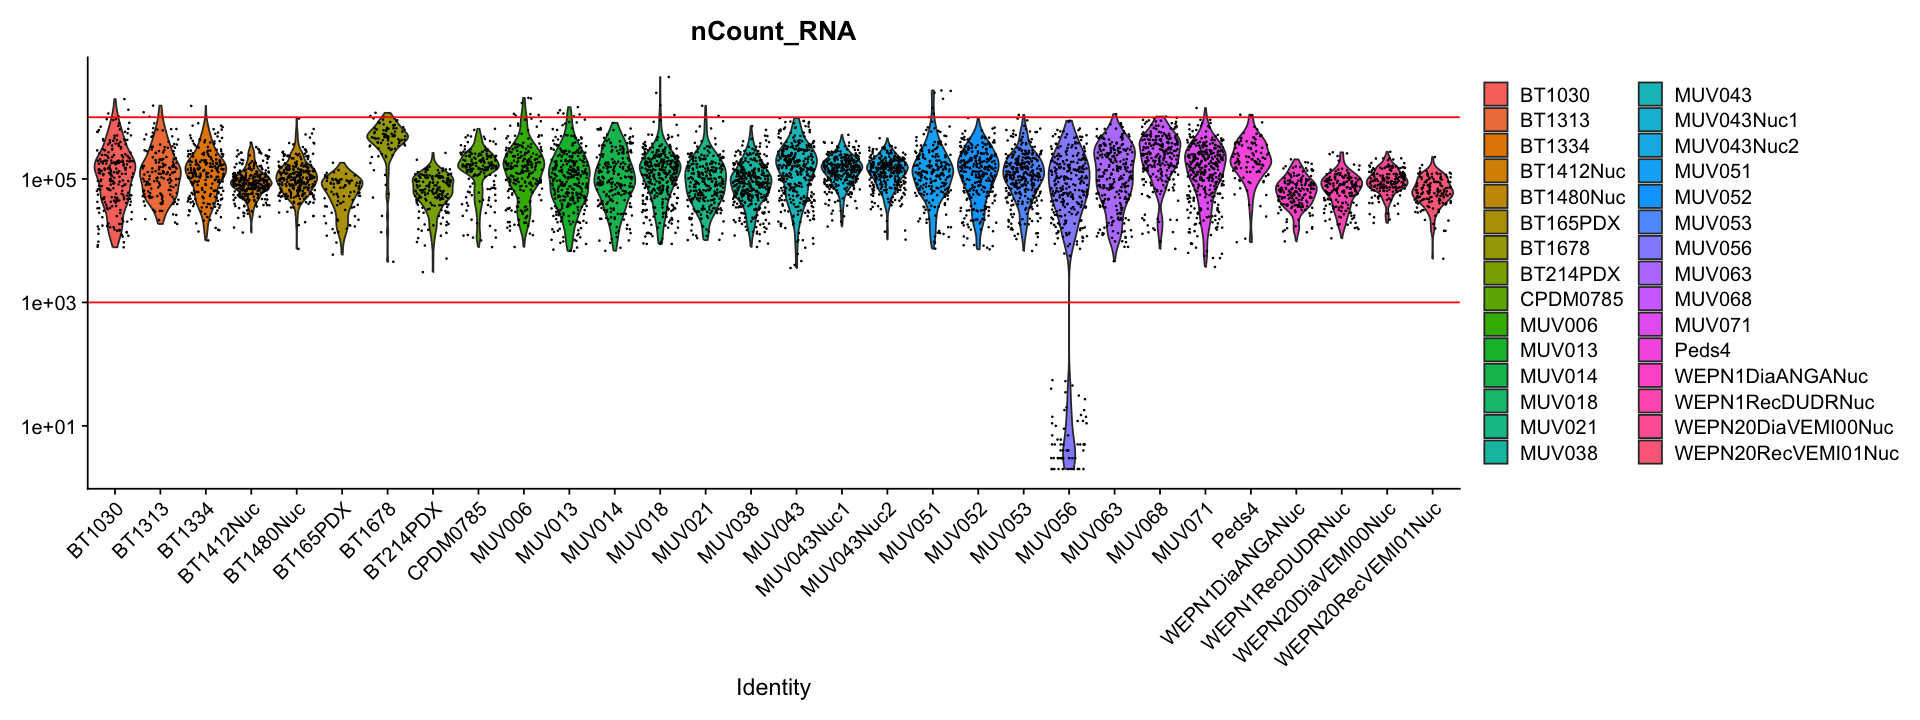

An object of class Seurat 
23686 features across 7089 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 1 layer present: counts

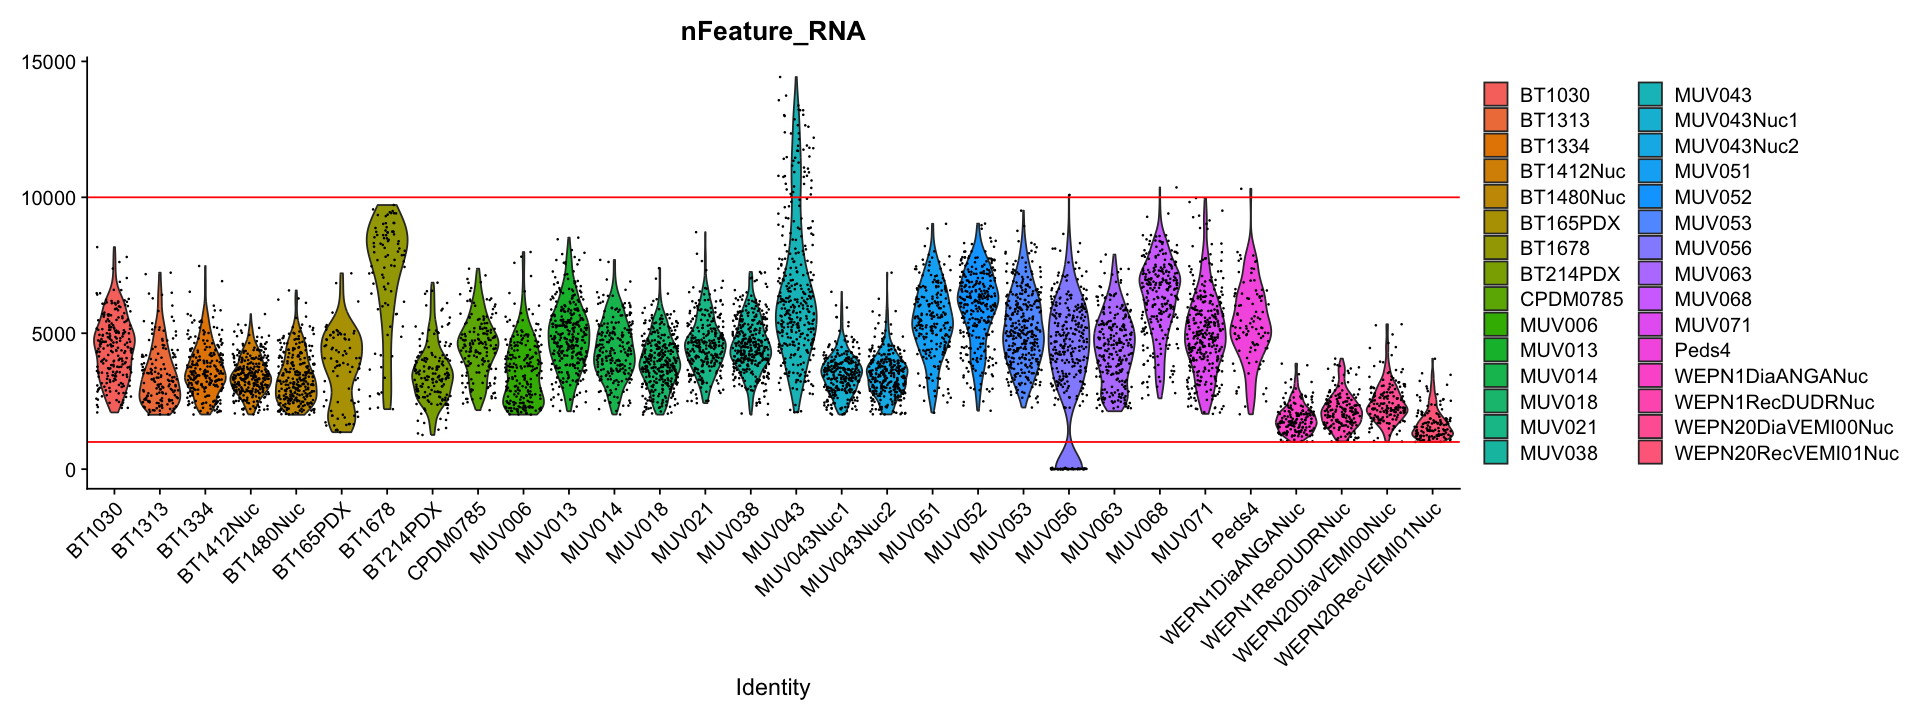

In [6]:
# Define QC thresholds
ncount_lower_threshold = 1000
ncount_upper_threshold = 1000000
nfeature_lower_threshold = 1000
nfeature_upper_threshold = 10000

# Plot threshods
options(repr.plot.width = 16, repr.plot.height =6)
VlnPlot(gojo, features="nCount_RNA", group.by='sample', log=TRUE) + 
    geom_hline(yintercept=ncount_lower_threshold, color='red') + 
    geom_hline(yintercept=ncount_upper_threshold, color='red')
VlnPlot(gojo, features="nFeature_RNA", group.by='sample') +
    geom_hline(yintercept=nfeature_lower_threshold,color='red') + 
    geom_hline(yintercept=nfeature_upper_threshold,color='red')

# apply QC filter
gojo<-subset(gojo, nFeature_RNA > nfeature_lower_threshold & nFeature_RNA < nfeature_upper_threshold &
                        nCount_RNA > ncount_lower_threshold & nCount_RNA < ncount_upper_threshold)
gojo
# 161 cells filtered

In [7]:
# scTransform should be performed per sample. See
# https://github.com/satijalab/seurat/issues/5306
# https://satijalab.org/seurat/archive/v4.3/sctransform_v2_vignette
gojo[["RNA"]] <- split(gojo[["RNA"]], f = gojo$sample)
DefaultAssay(gojo) <- "RNA"
gojo

An object of class Seurat 
23686 features across 7089 samples within 1 assay 
Active assay: RNA (23686 features, 0 variable features)
 30 layers present: counts.BT1313, counts.BT1334, counts.BT1412Nuc, counts.BT1480Nuc, counts.MUV013, counts.MUV014, counts.MUV018, counts.MUV021, counts.MUV038, counts.MUV051, counts.MUV052, counts.MUV053, counts.MUV063, counts.MUV071, counts.BT1678, counts.MUV068, counts.BT1030, counts.CPDM0785, counts.MUV006, counts.MUV043, counts.MUV043Nuc1, counts.MUV043Nuc2, counts.MUV056, counts.Peds4, counts.BT165PDX, counts.BT214PDX, counts.WEPN1DiaANGANuc, counts.WEPN1RecDUDRNuc, counts.WEPN20DiaVEMI00Nuc, counts.WEPN20RecVEMI01Nuc

In [8]:
# Normalization
# For details see https://satijalab.org/seurat/articles/sctransform_vignette.html
# This takes a long time (>1h on 12 cores)
gojo <- SCTransform(gojo, verbose = TRUE)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts.BT1313

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 13542 by 158

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 158 cells

Second step: Get residuals using fitted parameters for 13542 genes

Computing corrected count matrix for 13542 genes

Calculating gene attributes

Wall clock passed: Time difference of 18.90134 secs

Determine variable features

Centering data matrix

Running SCTransform on layer: counts.BT1334

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 14616 by 234

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 234 cells

Second step: Get residuals using fitted parameters for 14616 genes

Computing corrected c

In [9]:
# Checkpoint: normalization took forever so we save this as an .rds file
rds <- file.path('data','gojo_sctransformed_seuratobj.rds')
saveRDS(gojo, file = rds)

In [62]:
# Checkpoint: load this file if you don't want to wait an hour for SCTransform.
gojo <- readRDS(file = rds)
gojo

An object of class Seurat 
43296 features across 7089 samples within 2 assays 
Active assay: SCT (19610 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [63]:
# If we cluster and plot after normalization but before batch correction, we largely get a soup that doesn't segregate by
# sample or by annotation.
gojo <- RunPCA(gojo, verbose = FALSE, reduction.name="normalized.pca")
gojo <- RunUMAP(gojo, dims = 1:30, verbose = FALSE, reduction="normalized.pca",reduction.name="normalized.umap")
gojo <- FindNeighbors(gojo, dims = 1:30, verbose = FALSE, reduction="normalized.pca",graph.name="normalized.snn")
gojo <- FindClusters(gojo, verbose = FALSE, graph.name="normalized.snn", cluster.name="normalized.clusters")


Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Only one graph name supplied, storing nearest-neighbor graph only

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


[1] "Cluster similarity to sample IDs: " "0.0380433063136533"                
[1] "Cluster similarity to cell types: " "0.0699459155204983"                


Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


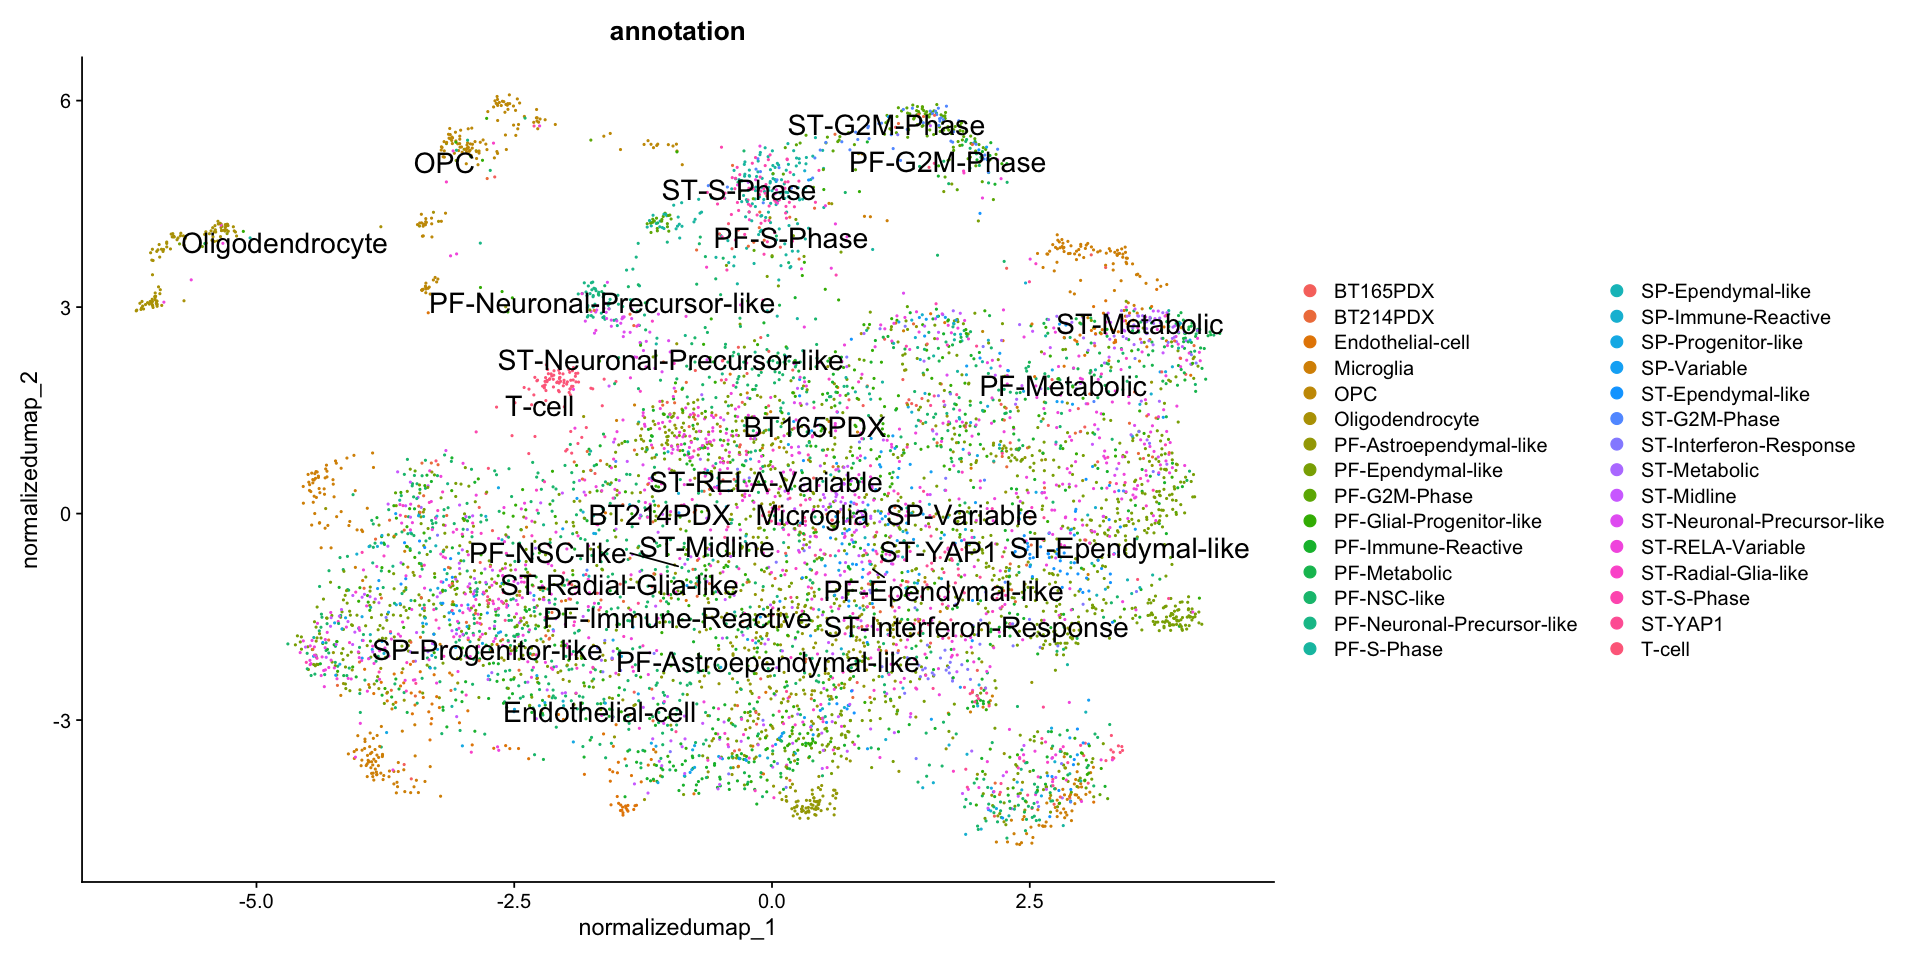

In [64]:
print(c('Cluster similarity to sample IDs: ',mclust::adjustedRandIndex(
    gojo[[]]$sample,
    gojo[[]]$normalized.clusters)))
print(c('Cluster similarity to cell types: ',mclust::adjustedRandIndex(
    gojo[[]]$annotation,
    gojo[[]]$normalized.clusters)))

options(repr.plot.width = 16, repr.plot.height =8)
DimPlot(gojo, reduction="normalized.umap", label=TRUE, group.by="annotation", label.size=6, repel=TRUE)

In [85]:
# Batch correction
# TODO: wrap in function
gojo <- gojo %>% IntegrateLayers(
    method = HarmonyIntegration,
    orig.reduction = "normalized.pca", new.reduction = "harmony",
    normalization.method = "SCT"
)
gojo <- RunUMAP(gojo, dims = 1:30, verbose = FALSE, reduction="harmony",reduction.name="harmony.umap")
gojo <- FindNeighbors(gojo, dims = 1:30, verbose = FALSE, reduction="harmony",graph.name="harmony.snn")
gojo <- FindClusters(gojo, verbose = FALSE, graph.name="harmony.snn", cluster.name="harmony.clusters")

print(c('Cluster similarity to sample IDs: ',mclust::adjustedRandIndex(
    gojo[[]]$sample,
    gojo[[]]$harmony.clusters)))
print(c('Cluster similarity to cell types: ',mclust::adjustedRandIndex(
    gojo[[]]$annotation,
    gojo[[]]$harmony.clusters)))


Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Transposing data matrix

Using automatic lambda estimation

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'i' in selecting a method for function '[[': object 'method' not found


Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


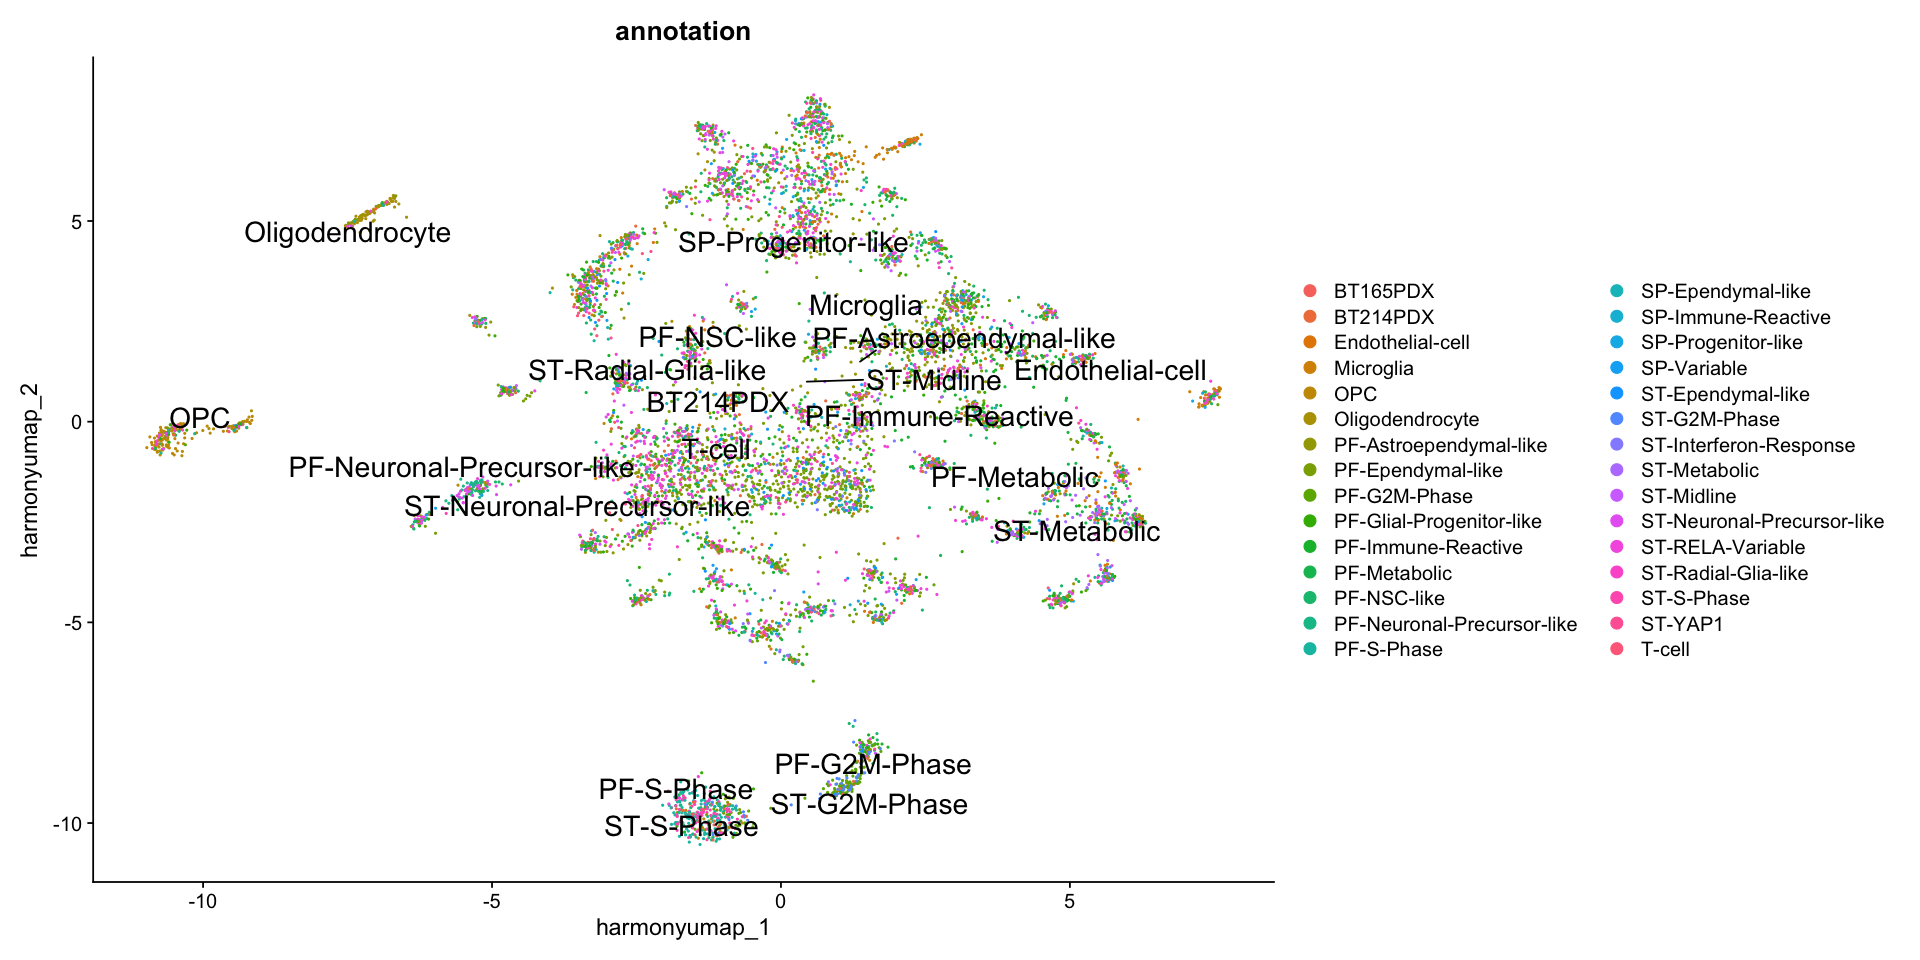

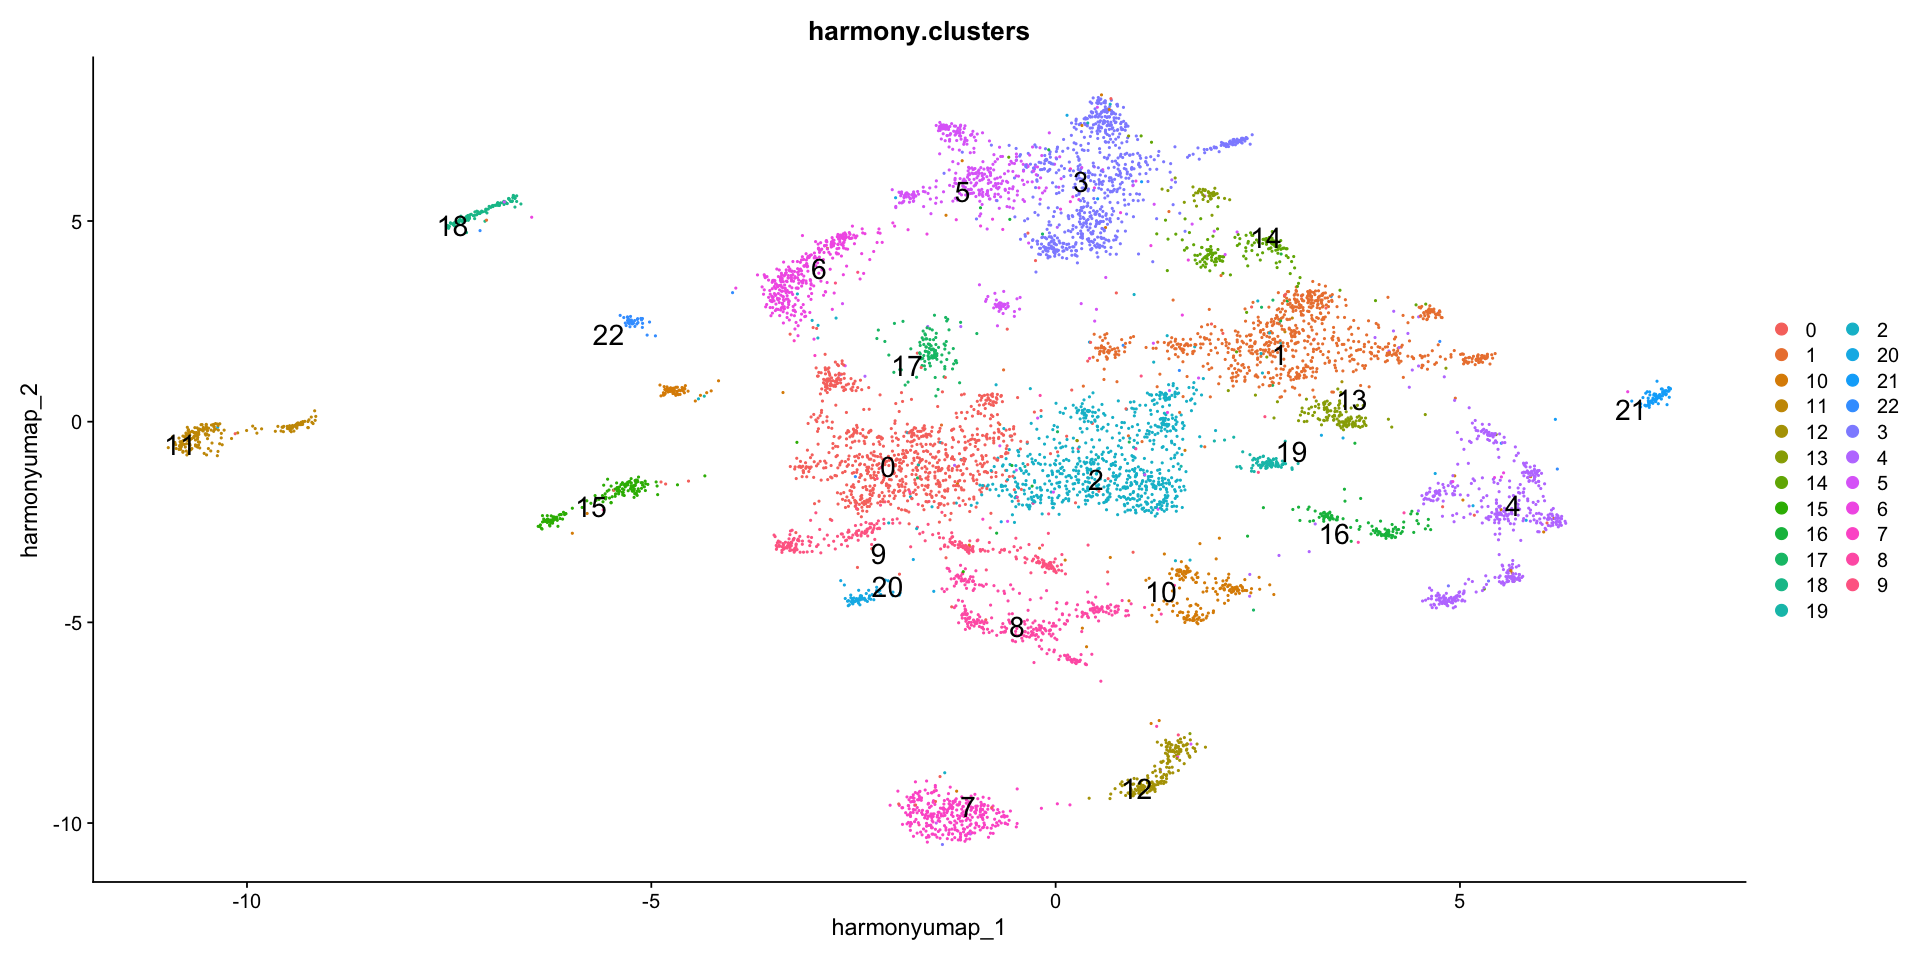

In [78]:
options(repr.plot.width = 16, repr.plot.height =8)
DimPlot(gojo, reduction="harmony.umap", label=TRUE, group.by="annotation", label.size=6, repel=TRUE)
DimPlot(gojo, reduction="harmony.umap", label=TRUE, group.by="harmony.clusters", label.size=6, repel=TRUE)

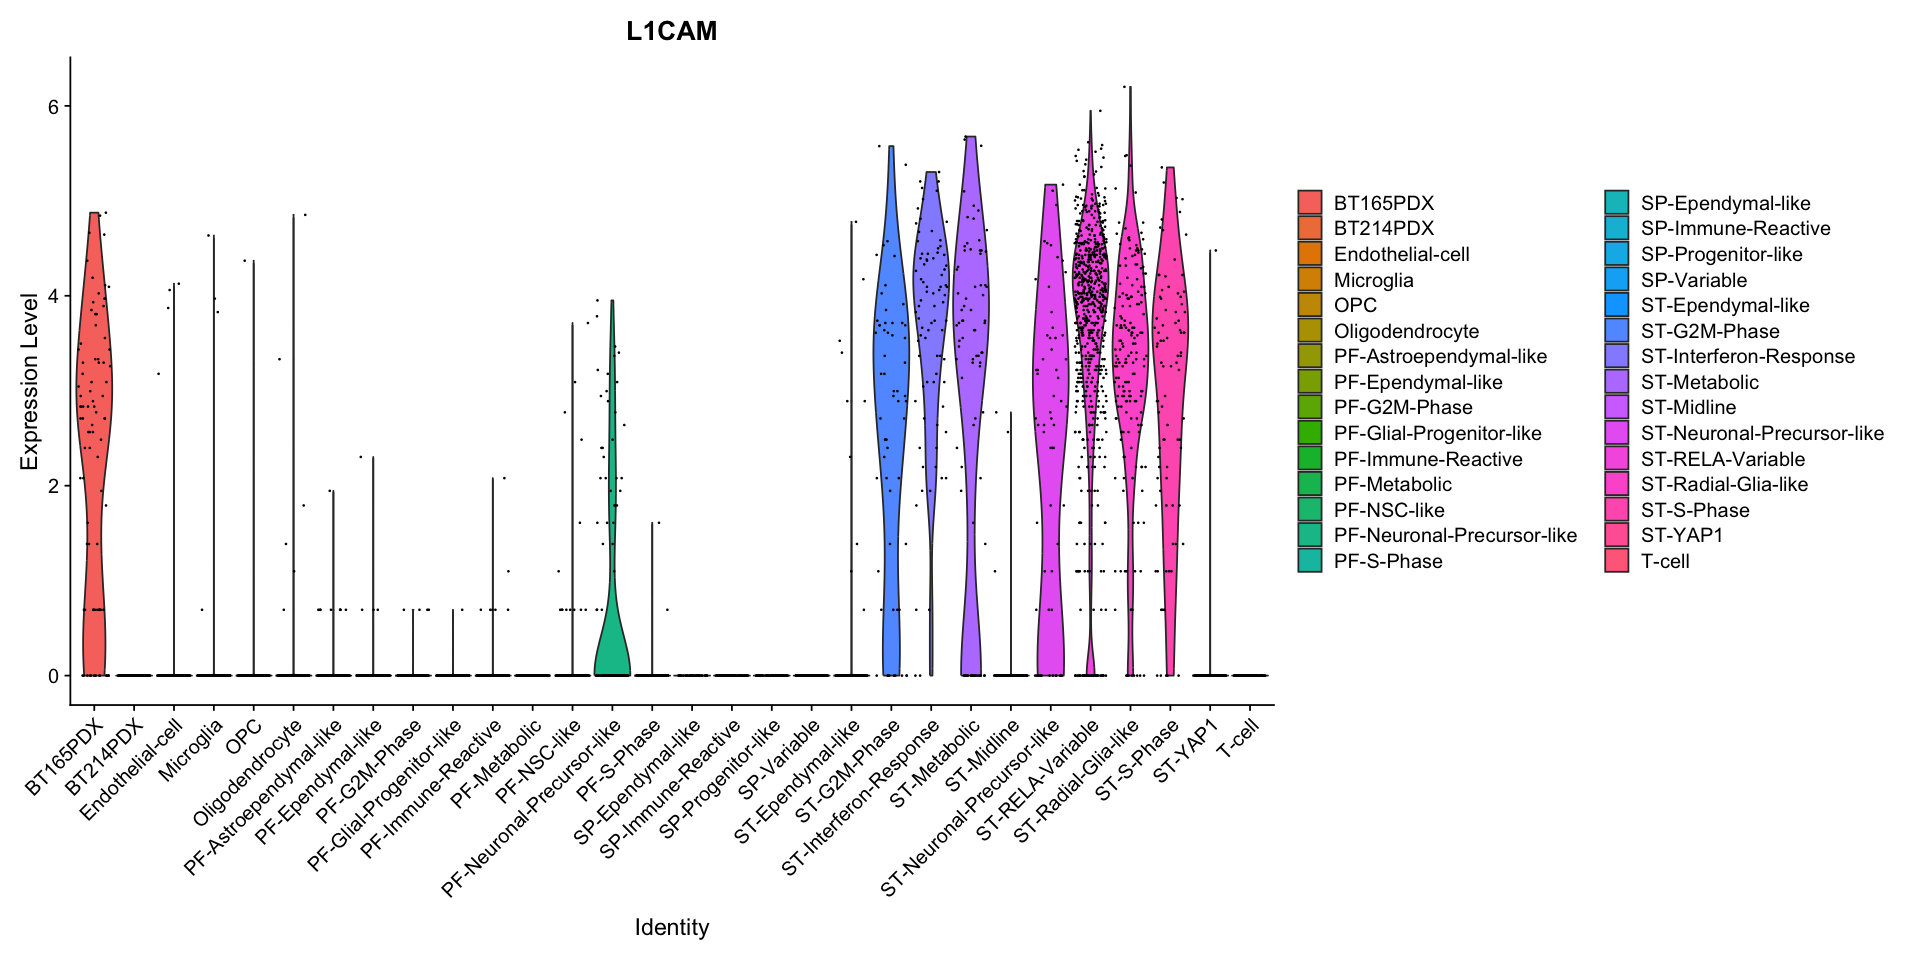

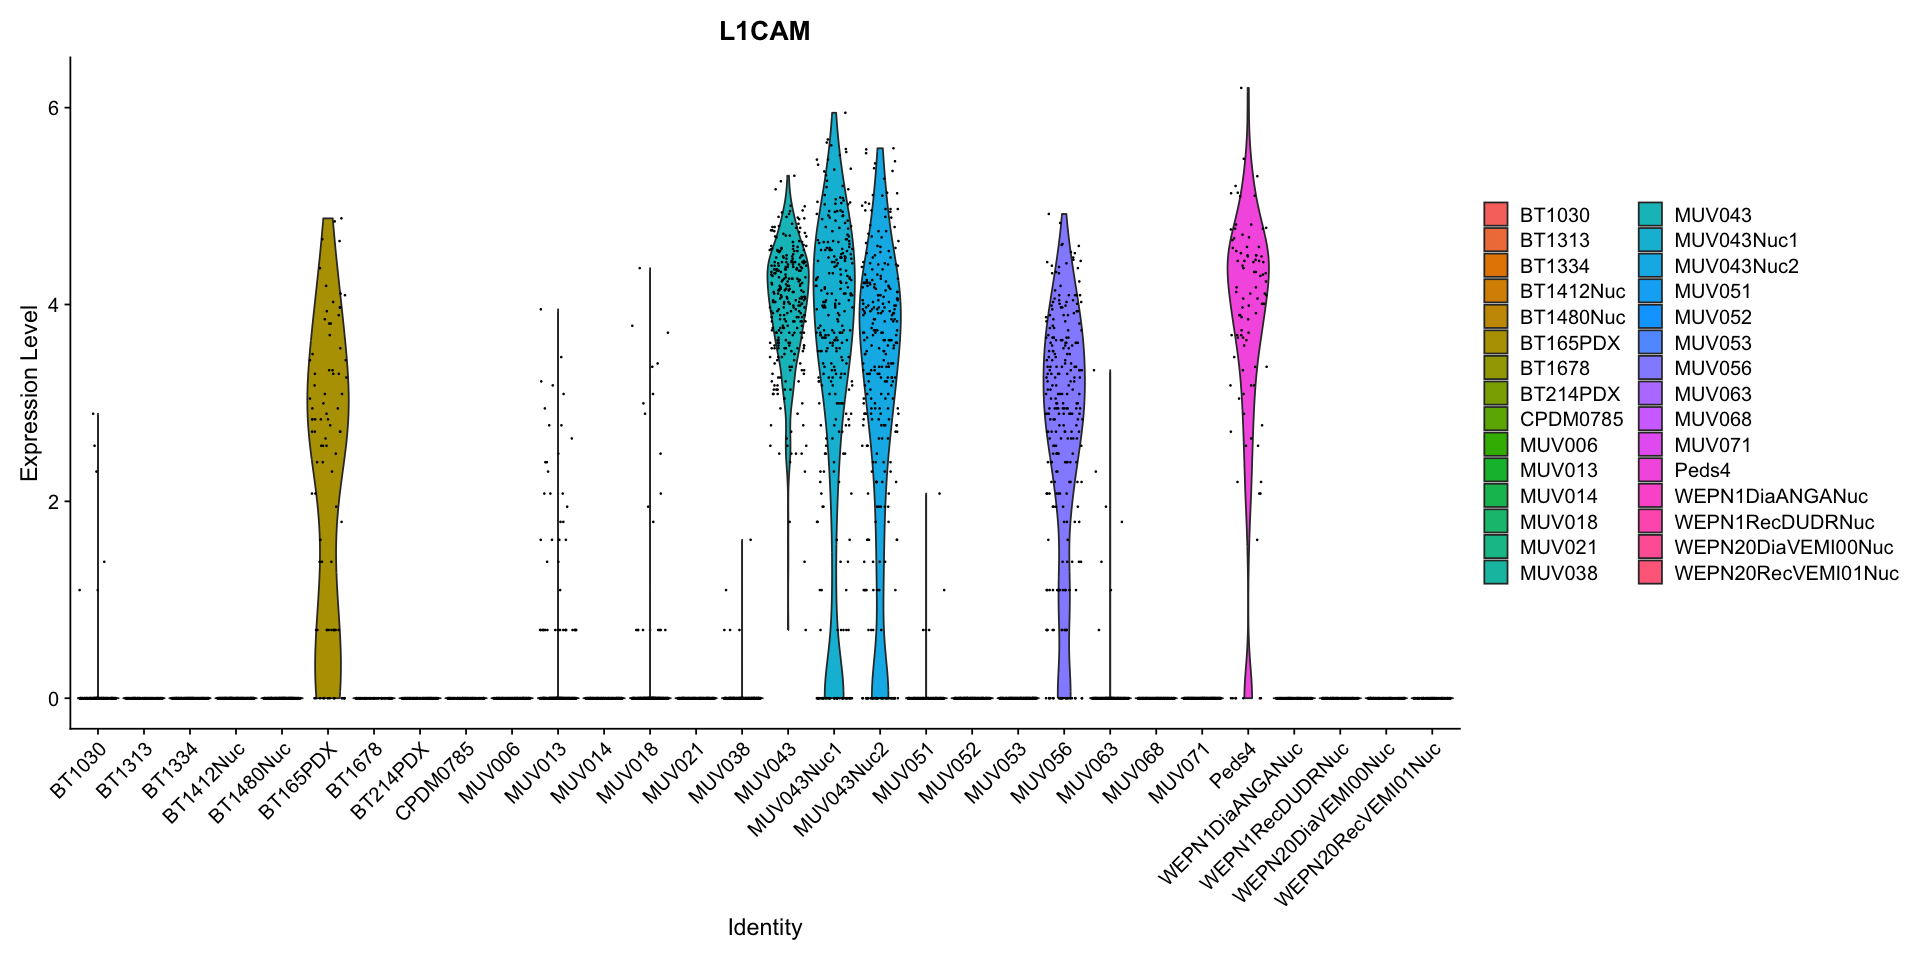

In [15]:
VlnPlot(gojo, features = 'L1CAM', group.by='annotation')
# L1CAM restricted to PF-Neuronal-Precursor-like and ST cell types.
VlnPlot(gojo, features = 'L1CAM', group.by='sample')
# BT1030 and CPDM0785 do not resemble RELA ependymomas in L1CAM expression.
# MUV006 (ST-YAP1) does not express L1CAM.

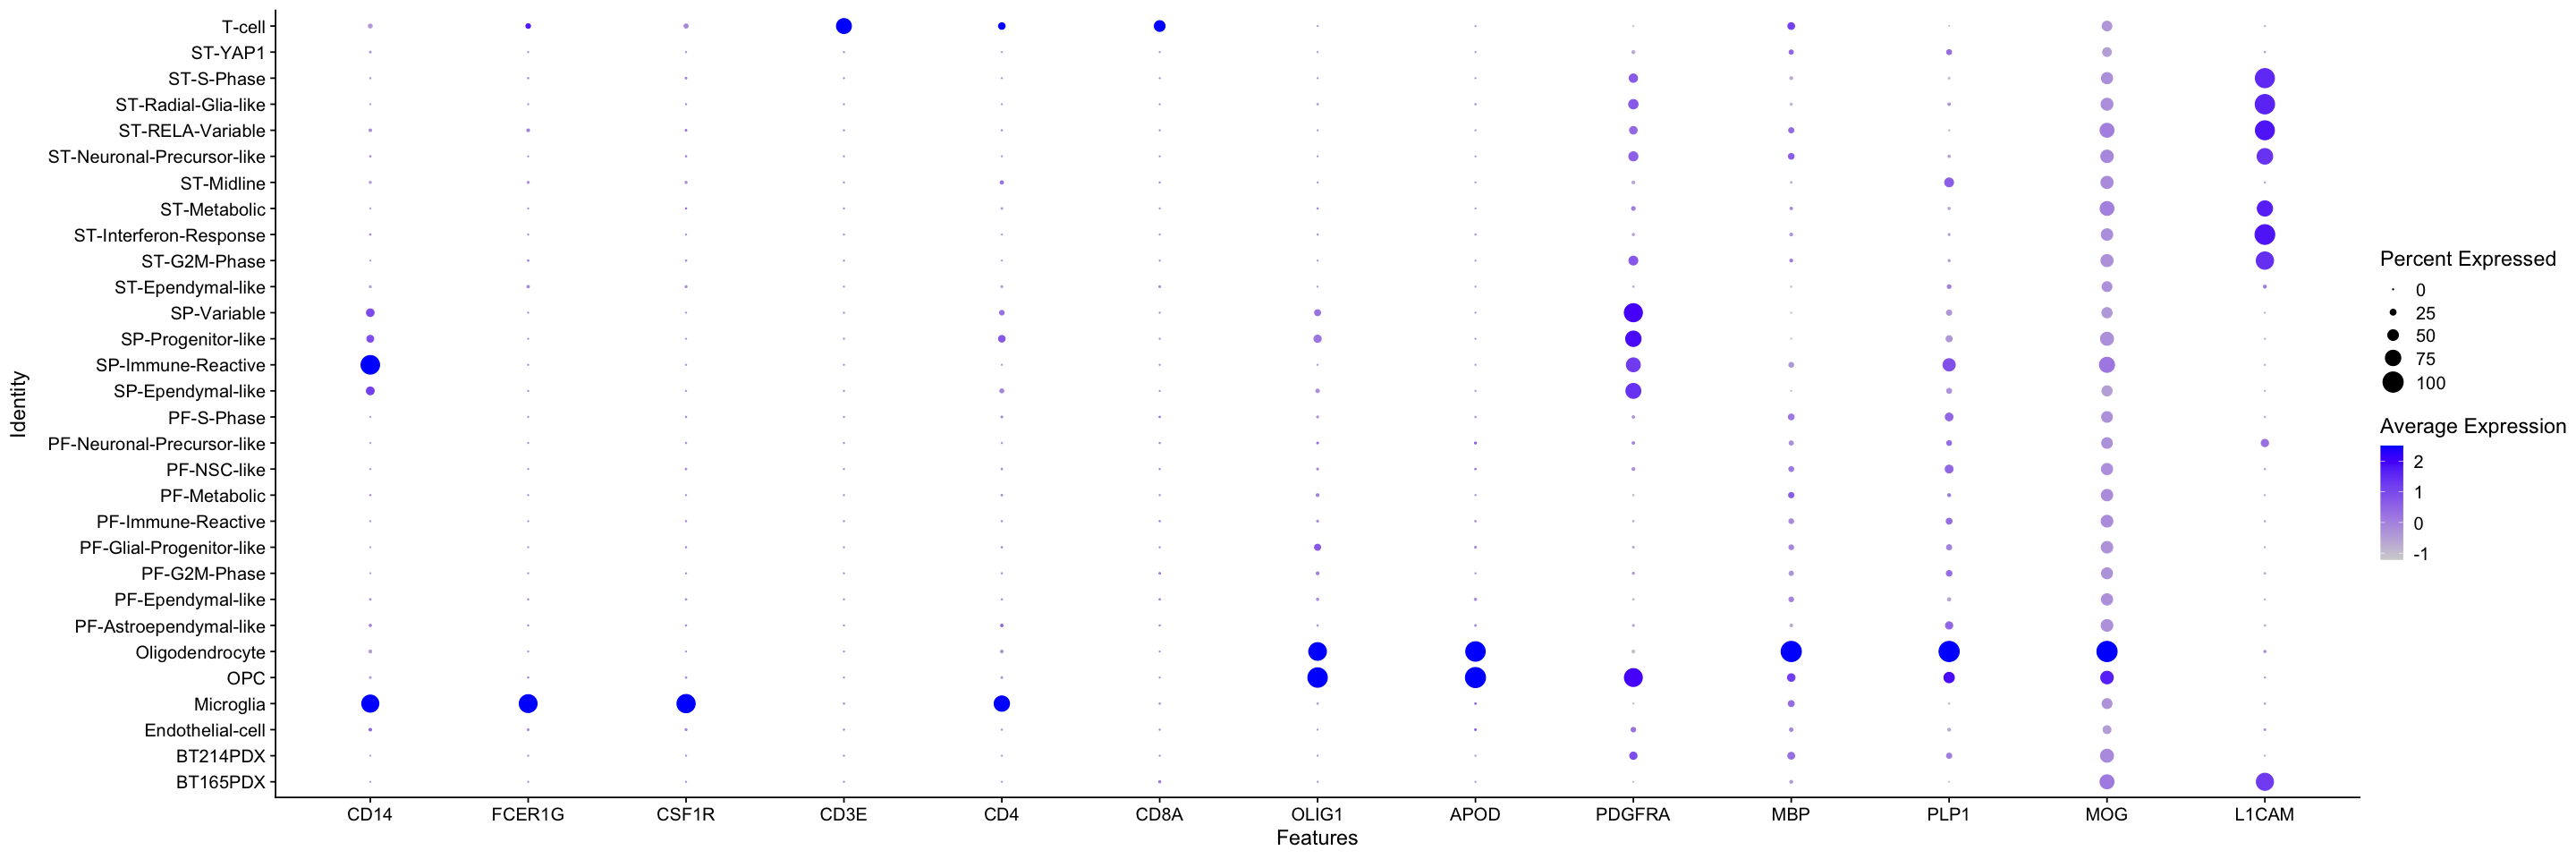

In [17]:
microglia_markers = c('CD14', 'FCER1G', 'CSF1R')
tcell_markers = c('CD3E', 'CD4', 'CD8A')
opc_markers = c('OLIG1', 'APOD', 'PDGFRA')
oligodendrocyte_markers = c('MBP', 'PLP1', 'MOG')
other_markers = c('L1CAM')
markers = c(microglia_markers,tcell_markers,opc_markers,oligodendrocyte_markers,other_markers)
DotPlot(gojo, features = markers, group.by = "annotation") #+ RotatedAxis()

# Less useful plots

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”


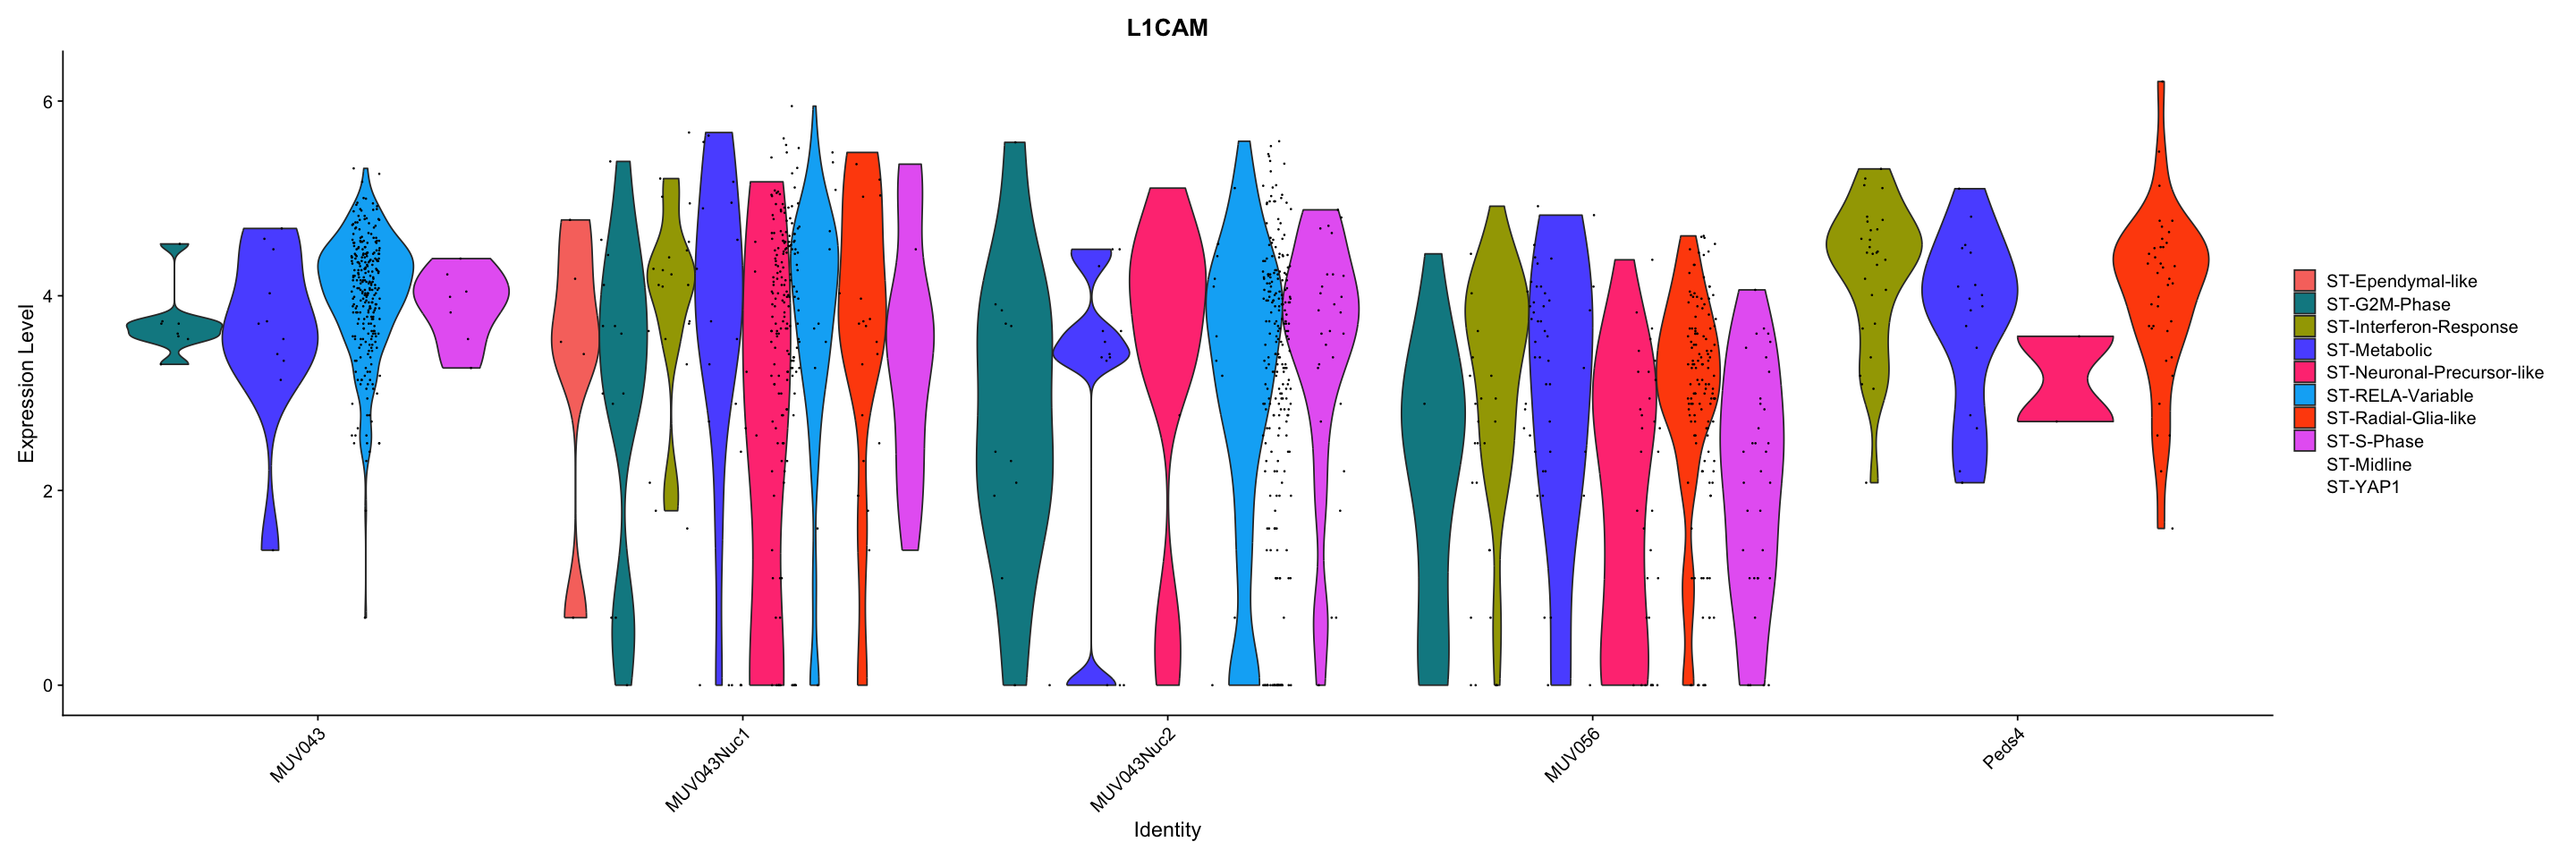

In [16]:
# take a closer look at only the ST ependymoma samples
options(repr.plot.width = 24, repr.plot.height=8)
gojo_subset = gojo %>% subset(
    sample %in% c('MUV043','MUV043Nuc1','MUV043Nuc2','MUV056','Peds4','BT165PDX') &
    annotation %in% c('ST-Ependymal-like','ST-G2M-Phase','ST-Interferon-Response','ST-Metabolic','ST-Midline','ST-Neuronal-Precursor-like','ST-RELA-Variable',
                     'ST-Radial-Glia-like','ST-S-Phase','ST-YAP1',NA)
)
VlnPlot(gojo_subset, features = 'L1CAM', split.by='annotation',group.by='sample')
# No obvious differences by cell type in within-sample variation of L1CAM.

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


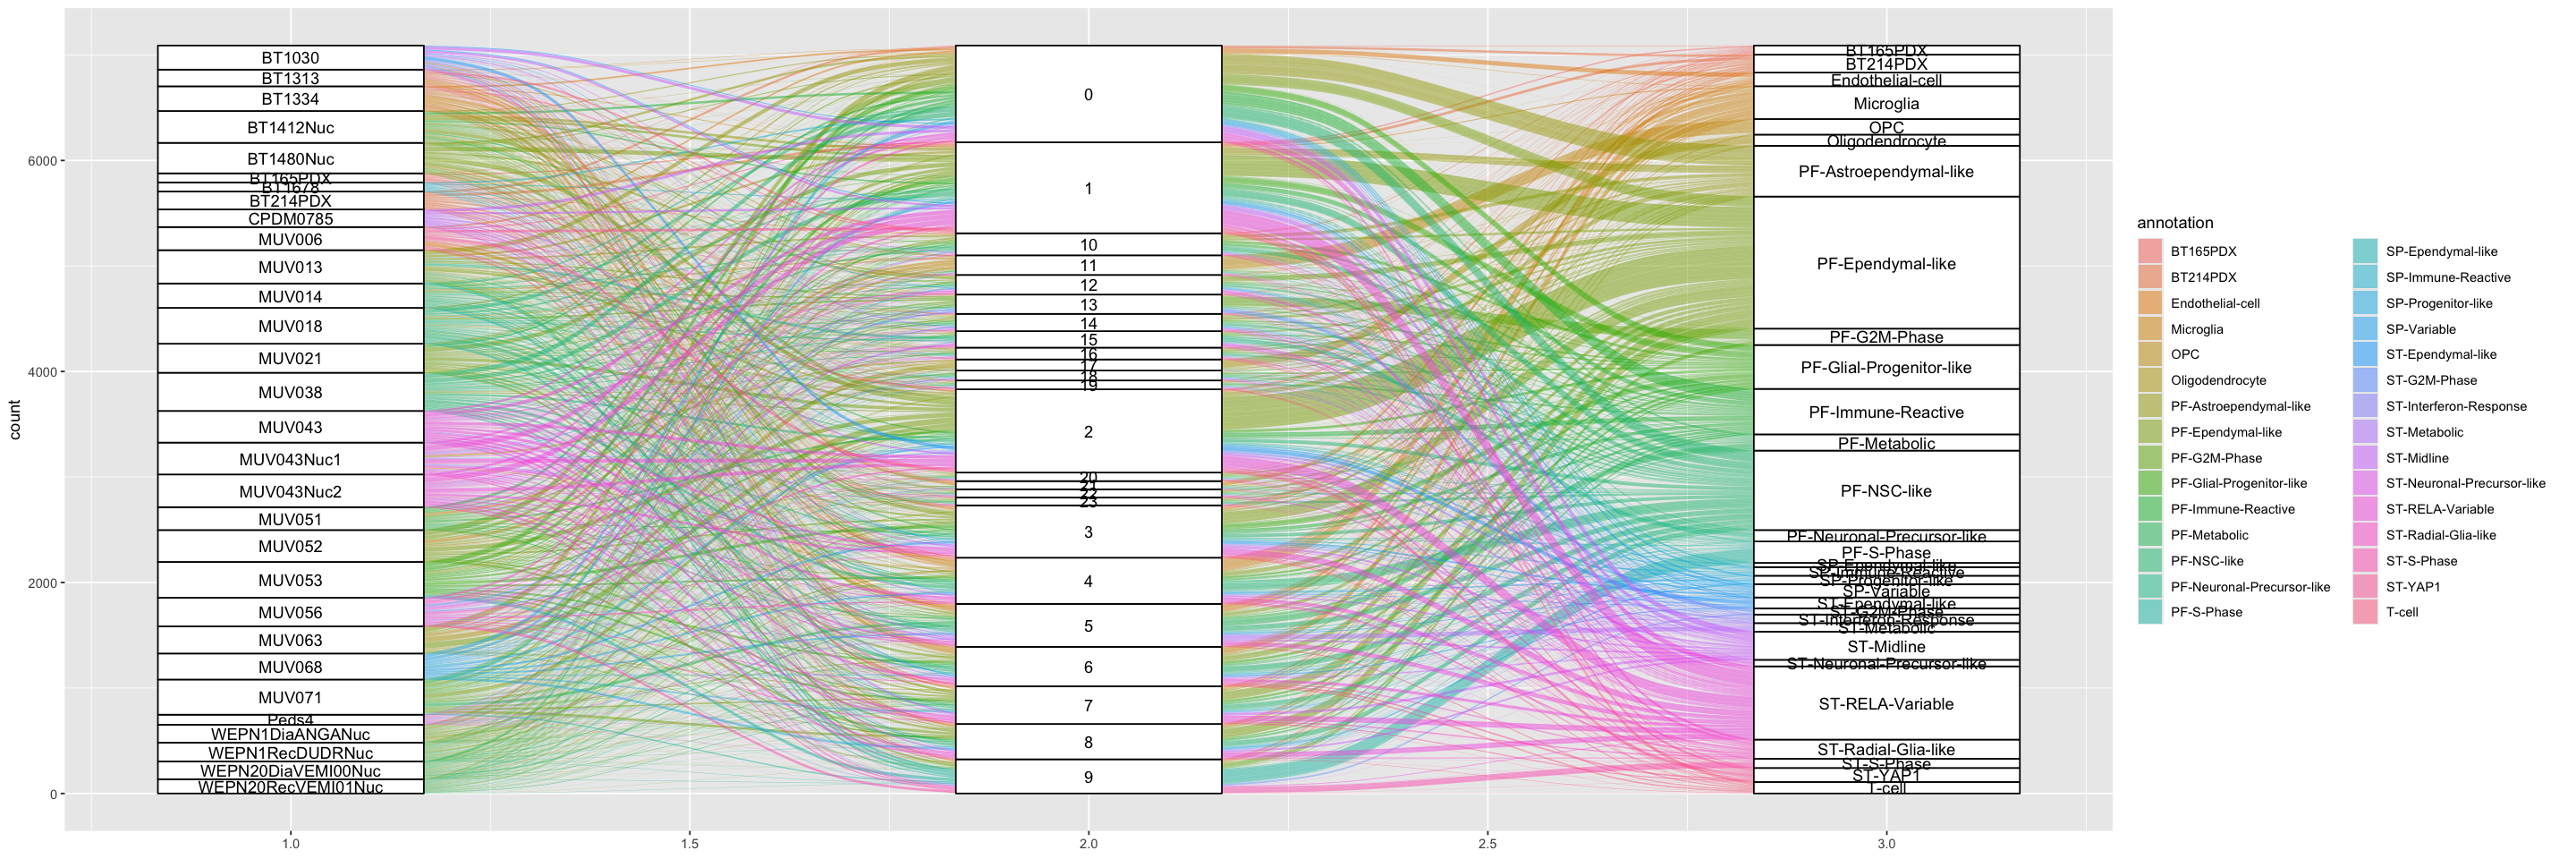

In [19]:
# Alluvial diagram; too complicated to be really useful.
frequency_table <- gojo[[]] %>%
  group_by(sample, harmony.clusters, annotation) %>%
  summarise(count = n(), .groups = 'drop')

ggplot(frequency_table,
       aes(axis1 = sample,
           axis2 = harmony.clusters,
           axis3 = annotation,
           y = count)) +
  geom_alluvium(aes(fill = annotation)) +
  geom_stratum() +
  geom_text(stat = "stratum", 
            aes(label = after_stat(stratum)))

# Trying other integrations

In [87]:
# Batch correction
# See https://satijalab.org/seurat/articles/integration_introduction#perform-integration-with-sctransform-normalized-datasets
gojo <- gojo %>% IntegrateLayers(
    method = CCAIntegration,
    orig.reduction = "normalized.pca", new.reduction = "cca",
    normalization.method = "SCT",
    k.weight=50
)
gojo <- RunUMAP(gojo, dims = 1:30, verbose = FALSE, reduction="cca",reduction.name="cca.umap")
gojo <- FindNeighbors(gojo, dims = 1:30, verbose = FALSE, reduction="cca",graph.name="cca.snn")
gojo <- FindClusters(gojo, verbose = FALSE, graph.name="cca.snn", cluster.name="cca.clusters")

print(c('Cluster similarity to sample IDs: ',mclust::adjustedRandIndex(
    gojo[[]]$sample,
    gojo[[]]$cca.clusters)))
print(c('Cluster similarity to cell types: ',mclust::adjustedRandIndex(
    gojo[[]]$annotation,
    gojo[[]]$cca.clusters)))


Finding all pairwise anchors

Warning message in size + sum(size_args, na.rm = FALSE):
“NAs produced by integer overflow”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 704 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 741 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1018 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 741 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 994 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1162 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 759 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1004 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1169 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anc

[1] "Cluster similarity to sample IDs: " "0.00988010599875346"               
[1] "Cluster similarity to cell types: " "0.038034749297124"                 


In [ ]:
frequency_table

In [ ]:
gojo[[]] %>% head